# 0. Particle segmentation

In this notebook, we attempt to train neural networks for particle segmentation

We use a slimmed down dataset of a public dataset from the [Deep Learn Physics Challenge](http://deeplearnphysics.org/DataChallenge/). The dataset is a set of images of five types particles (electron, gamma ray, muon, charged pion, and proton) projected in the xy-plane. For semantic segmentation, the images are labelled with three classes: background, EM-shower particles, and track particles (i.e. not EM-shower). 


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization, SeparableConv2D, UpSampling2D


# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join


# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

data_path = 'data'

Using TensorFlow v2.7.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

Our data are stored in the hdf files physics/phy_seg_train_img.h5, physics/phy_seg_train_lab.h5 and physics/phy_seg_test_img.h5, physics/phy_seg_test_lab.h5 containing 2,000 images and 2,000 labels, respectively.  
**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Physics/phy_seg_train_img.h5'), 'r') as F:
    x_train = np.expand_dims(np.array(F['images']), axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.

with h5py.File(join(data_path, 'Physics/phy_seg_train_lab.h5'), 'r') as F:
    y_train = np.expand_dims(np.array(F['labels']), axis = -1)
    y_train = y_train.astype(np.float32)

with h5py.File(join(data_path, 'Physics/phy_seg_test_img.h5'), 'r') as F:
    x_test = np.expand_dims(np.array(F['images']), axis = -1)
    x_test = x_test.astype(np.float32)
    x_test = x_test/255.

with h5py.File(join(data_path, 'Physics/phy_seg_test_lab.h5'), 'r') as F:
    y_test = np.expand_dims(np.array(F['labels']), axis = -1)
    y_test = y_test.astype(np.float32)
    
# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))
```
    
</p>
</details>

In [4]:
# load dataset
with h5py.File(join(data_path, 'Physics/phy_seg_train_img.h5'), 'r') as F:
    x_train = np.expand_dims(np.array(F['images']), axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.

with h5py.File(join(data_path, 'Physics/phy_seg_train_lab.h5'), 'r') as F:
    y_train = np.expand_dims(np.array(F['labels']), axis = -1)
    y_train = y_train.astype(np.float32)

with h5py.File(join(data_path, 'Physics/phy_seg_test_img.h5'), 'r') as F:
    x_test = np.expand_dims(np.array(F['images']), axis = -1)
    x_test = x_test.astype(np.float32)
    x_test = x_test/255.

with h5py.File(join(data_path, 'Physics/phy_seg_test_lab.h5'), 'r') as F:
    y_test = np.expand_dims(np.array(F['labels']), axis = -1)
    y_test = y_test.astype(np.float32)
    
# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))

Number of training data: 2000
Number of test data: 2000
Image pixels: (256, 256)
Number of channels: 1


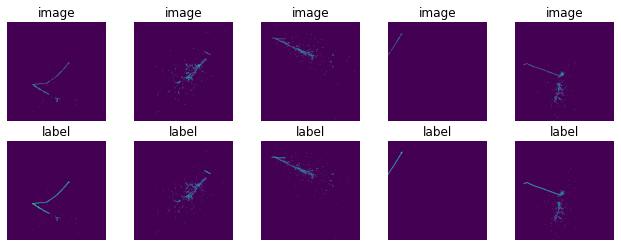

In [5]:
fig, axes = plt.subplots(2, 5, figsize = (11, 4))
for i in range(5):
    rnd_idx = np.random.choice(len(x_train), 1)[0]
    axes[0][i].imshow(x_train[rnd_idx].reshape(256, 256))
    axes[0][i].set_title('image')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_train[rnd_idx].reshape(256, 256))
    axes[1][i].set_title('label')
    axes[1][i].axis('off')
    


---

# 2. Build the network

We use U-Net Xception-style model following [Keras official document](https://keras.io/examples/vision/oxford_pets_image_segmentation/). 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
inputs = tf.keras.Input(shape=(256, 256, 1))

### [First half of the network: downsampling inputs] ###

# Entry block
x = Conv2D(32, 3, strides=2, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)

previous_block_activation = x  # Set aside residual

# Blocks 1, 2, 3 are identical apart from the feature depth.
for filters in [64, 128, 256]:
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

for filters in [256, 128, 64, 32]:
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    # Project residual
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

# Add a per-pixel classification layer
outputs = Conv2D(3, 3, activation="softmax", padding="same")(x)

# Define the model
model = tf.keras.Model(inputs, outputs)

model.summary()
```
    
</p>
</details>

In [6]:
inputs = tf.keras.Input(shape=(256, 256, 1))

### [First half of the network: downsampling inputs] ###

# Entry block
x = Conv2D(32, 3, strides=2, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)

previous_block_activation = x  # Set aside residual

# Blocks 1, 2, 3 are identical apart from the feature depth.
for filters in [64, 128, 256]:
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

for filters in [256, 128, 64, 32]:
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    # Project residual
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

# Add a per-pixel classification layer
outputs = Conv2D(3, 3, activation="softmax", padding="same")(x)

# Define the model
model = tf.keras.Model(inputs, outputs)

model.summary()

2022-03-28 12:14:57.063272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 12:14:57.601710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14773 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### Compile and train the model

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy())

# train the model
training_history = model.fit(x_train, y_train, epochs=10, batch_size=32)
```
    
</p>
</details>

In [7]:
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy())

# train the model
training_history = model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2022-03-28 12:15:01.623138: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-28 12:15:02.177753: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 12:15:02.178556: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 12:15:02.178606: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-28 12:15:02.179533: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 12:15:02.179675: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


63/63 [==============================] - 27s 347ms/step - loss: 0.3621
Epoch 2/10
63/63 [==============================] - 21s 329ms/step - loss: 0.0456
Epoch 3/10
63/63 [==============================] - 21s 332ms/step - loss: 0.0352
Epoch 4/10
63/63 [==============================] - 21s 333ms/step - loss: 0.0311
Epoch 5/10
63/63 [==============================] - 21s 332ms/step - loss: 0.0282
Epoch 6/10
63/63 [==============================] - 21s 333ms/step - loss: 0.0269
Epoch 7/10
63/63 [==============================] - 21s 333ms/step - loss: 0.0262
Epoch 8/10
63/63 [==============================] - 21s 334ms/step - loss: 0.0256
Epoch 9/10
63/63 [==============================] - 21s 333ms/step - loss: 0.0250
Epoch 10/10
63/63 [==============================] - 21s 339ms/step - loss: 0.0245


---

# 3. Analyse results 

### Check training history

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
plt.figure
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

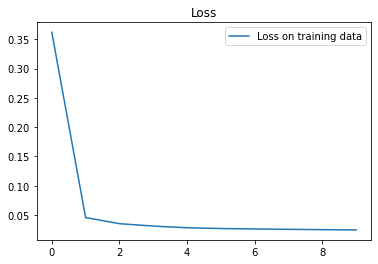

In [8]:
plt.figure
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.legend()
plt.title("Loss")
plt.show()

### Make predictions

In [9]:
# use a batch of test images to predict
batch = x_test[:32]
pred_labels = model.predict(batch).argmax(axis=-1)

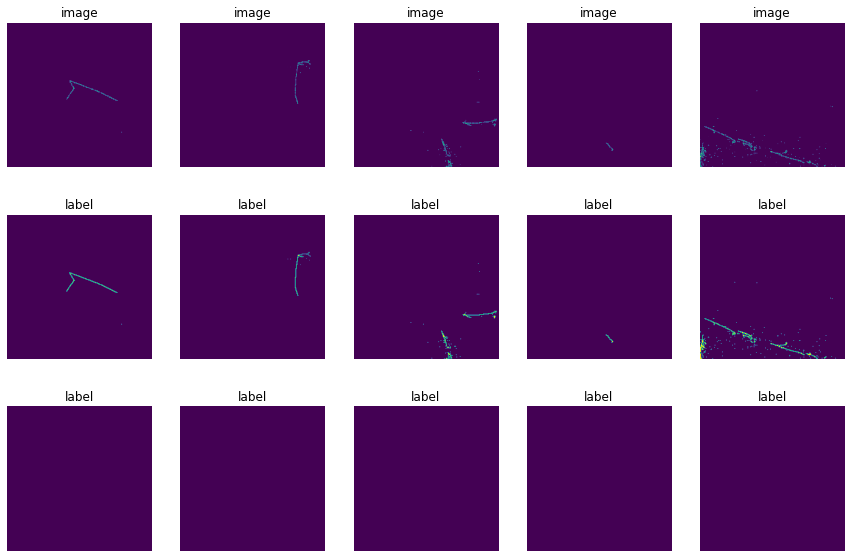

In [10]:
fig, axes = plt.subplots(3, 5, figsize = (15, 10))
for i in range(5):
    rnd_idx = np.random.choice(len(batch), 1)[0]
    axes[0][i].imshow(x_test[rnd_idx].reshape(256, 256))
    axes[0][i].set_title('image')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_test[rnd_idx].reshape(256, 256))
    axes[1][i].set_title('label')
    axes[1][i].axis('off')
    axes[2][i].imshow(pred_labels[rnd_idx].reshape(256, 256))
    axes[2][i].set_title('label')
    axes[2][i].axis('off')     

---

# 4.Exercises

Think segmentation as a classification task on pixel level. In this case, the number of background is much greater than the number of EM-shower particles and track particles, which causes label imbalance. 

* Add more convolutional layers
* Weight EM-shower particles and track particles labels